In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
models = {'svm': LinearSVC(), 
          'log_reg': LogisticRegression(), 
          'naive_baives': MultinomialNB(), 
          'knn': KNeighborsClassifier(),
          'dec_tree': DecisionTreeClassifier()}

In [23]:
df = pd.read_csv('data/train_small.csv')
#df.sample(100000).to_csv('test_small.csv', encoding='utf-8')
#df.fillna()

In [11]:
df_train, df_test = train_test_split(df.sample(10000), test_size = 0.2)
len(df_train), len(df_test)

(8000, 2000)

In [17]:
#df.describe
df.columns

Index(['Unnamed: 0', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

array([91, 36, 11, 39, 98, 21, 47, 23,  3, 66,  1, 52,  2, 78, 65, 55, 59,
       10, 46, 27, 99, 95, 25, 70, 28, 89, 85, 94, 96, 33, 77, 58, 68, 38,
       83,  5, 32, 92, 49, 30, 97, 60, 42, 48,  7, 63, 29, 20, 69, 81, 64,
        4, 18, 40, 34, 16, 84, 72, 90, 12, 56, 17, 15, 54, 76, 93,  6,  0,
       44, 26, 41, 73, 37, 50, 57, 82, 43, 45, 61, 24,  9, 75, 62, 35, 19,
       67, 86, 51, 87,  8, 13, 74, 22, 79, 88, 53, 80, 71, 31, 14])

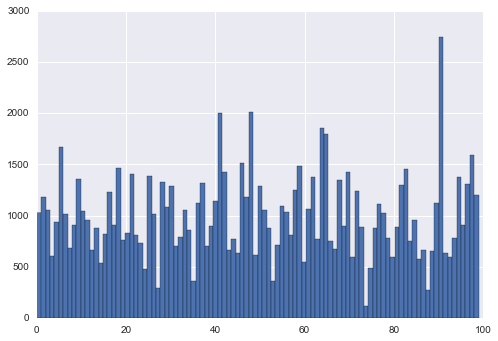

In [15]:
df.hotel_cluster.hist(bins=100)
df.hotel_cluster.unique()

Ideas
Customer personas based on how far, with children, multiple destinations, how long staying, when booked, how booked, 
user books a lot
user books alone sometimes and sometimes with children
location is seasonal - warm, holiday

users loyal to a brand



In [18]:
#[(col, dtype) for col, dtype in zip(df.columns, df.dtypes) if dtype != 'object']
num_columns = [col for col, dtype in zip(df.columns, df.dtypes) if dtype != 'object']
num_columns

['Unnamed: 0',
 'site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'orig_destination_distance',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'hotel_cluster']

In [32]:
feature_cols = ['site_name',
             'posa_continent',
             'user_location_country',
             'user_location_region',
             'user_location_city',
             'is_mobile',
             'is_package',
             'channel',
             'srch_adults_cnt',
             'srch_children_cnt',
             'srch_rm_cnt',
             'srch_destination_id',
             'srch_destination_type_id',
             'is_booking',
             'cnt',
             'hotel_continent',
             'hotel_country',
             'hotel_market']
X_train = df_train[feature_cols]
y_train = df_train.hotel_cluster

X_test = df_test[feature_cols]
y_test = df_test.hotel_cluster

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
df_test['pred'] = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, df_test.pred)

0.059499999999999997

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
Unnamed: 0                   100000 non-null int64
date_time                    100000 non-null object
site_name                    100000 non-null int64
posa_continent               100000 non-null int64
user_location_country        100000 non-null int64
user_location_region         100000 non-null int64
user_location_city           100000 non-null int64
orig_destination_distance    64302 non-null float64
user_id                      100000 non-null int64
is_mobile                    100000 non-null int64
is_package                   100000 non-null int64
channel                      100000 non-null int64
srch_ci                      99865 non-null object
srch_co                      99865 non-null object
srch_adults_cnt              100000 non-null int64
srch_children_cnt            100000 non-null int64
srch_rm_cnt                  100000 non-null int64
srch_destination_id  

In [62]:
def user_analysis(group):
    total_bookings = group['user_id'].count()
    group['total_bookings'] = total_bookings
    group['favorite_hotel'] = group.hotel_cluster.value_counts().index[0]
    times_at_favorite = group.hotel_cluster.value_counts().tolist()[0]
    if total_bookings > 2:
        group['loyalty'] = times_at_favorite / total_bookings
    else:
        # use average loyalty for freq travelers
        group['loyalty'] = 0.19
    return group
    

df_freq = df.groupby('user_id').apply(user_analysis)

In [70]:
df_freq[df_freq.total_bookings > 2].sort_values(['total_bookings','user_id'], ascending=False)[['user_id', 'hotel_cluster', 'total_bookings', 'favorite_hotel', 'loyalty']].mean()

user_id           610826.211888
hotel_cluster         50.276454
total_bookings         3.200871
favorite_hotel        52.695619
loyalty                0.376377
dtype: float64

In [61]:
df[df.user_id == 873383].hotel_cluster.value_counts().tolist()[0] #[0] #.type #.tolist()

4

In [71]:
df_loyalty = pd.read_csv('data/train.csv', usecols = ['user_id',
       'hotel_market', 'hotel_cluster'], nrows=1000000).dropna()

In [94]:
df_profile = pd.read_csv('data/train.csv', usecols = ['user_id',
       'hotel_market', 'hotel_cluster', 'is_mobile', 'is_package', 
        'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 
        'srch_rm_cnt'], nrows=1000000).dropna()



In [130]:
df_profile['trip_start'] = pd.to_datetime(df['srch_ci'])
df_profile['trip_end'] = pd.to_datetime(df['srch_co'])
df_profile['trip_length'] = (df_profile.trip_end - df_profile.trip_start).astype('timedelta64[D]')

# get average trip length and replace nan, neg values and zero
#df_profile[df_profile.trip_length > 0].mean() # average is 3.4 days
df_profile.loc[((df_profile.trip_length.isnull()) | (df_profile.trip_length < 1)), 'trip_length'] = 3.4
df_profile['trip_start_day'] = df_profile.trip_start.dt.dayofweek
df_profile.trip_length.max()

240.0

In [131]:
df_cprof = df_profile.groupby('user_id').apply(user_analysis)

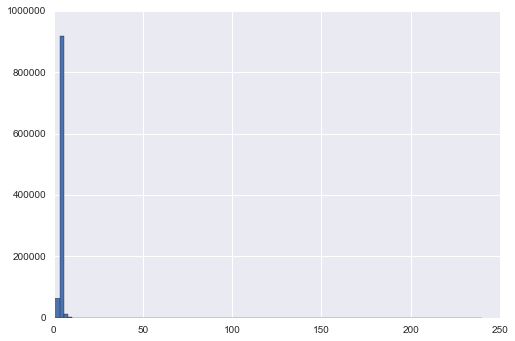

In [132]:
df_cprof.trip_length.hist(bins=100)

In [78]:
df_freq2[df_freq2.total_bookings == 2].sort_values(['total_bookings','user_id'], ascending=False)[['user_id', 'hotel_cluster', 'total_bookings', 'favorite_hotel', 'loyalty']].count()

user_id           1630
hotel_cluster     1630
total_bookings    1630
favorite_hotel    1630
loyalty           1630
dtype: int64

Index(['user_id', 'hotel_market', 'hotel_cluster', 'total_bookings',
       'favorite_hotel', 'loyalty'],
      dtype='object')

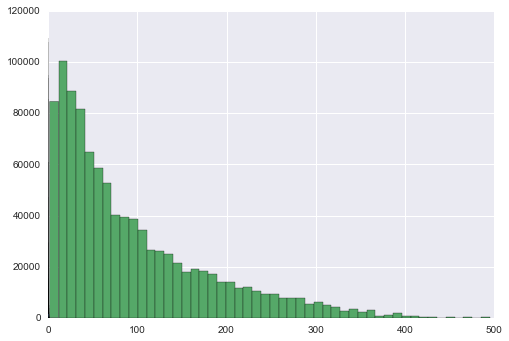

In [97]:
df_freq2.total_bookings.hist(bins=50)
df_freq2.columns

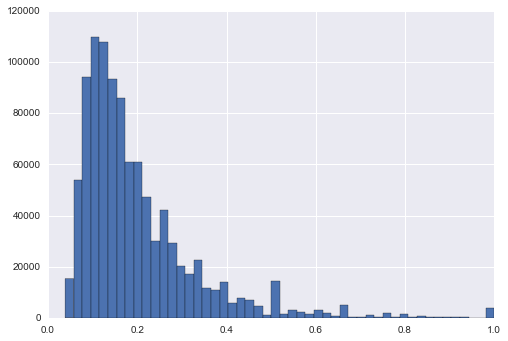

In [109]:
df_cprof.loyalty.hist(bins=50)


In [134]:
df_train, df_test = train_test_split(df_cprof, test_size = 0.2)
len(df_train), len(df_test)

(799200, 199801)

In [139]:
feature_cols = ['user_id', 'hotel_market', 'total_bookings',
       'favorite_hotel']
X_train = df_train[feature_cols]
y_train = df_train.hotel_cluster

X_test = df_test[feature_cols]
y_test = df_test.hotel_cluster

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
df_test['pred'] = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, df_test.pred)

/Users/steven/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.30038888694250782

In [140]:
df_submit = pd.read_csv('data/test.csv')

In [ ]:
# def test_user_analysis(group):
#     user_id = group.user_id.min()
#     total_bookings = group['user_id'].count() + df_cprof[df_cprof.user_id == user_id].total_bookings.min()
#     group['total_bookings'] = total_bookings
#     group['favorite_hotel'] = df_cprof[df_cprof.user_id == user_id].favorite_hotel.min()
#     #times_at_favorite = group.hotel_cluster.value_counts().tolist()[0]
#     if total_bookings > 2:
#         group['loyalty'] = df_cprof[df_cprof.user_id == user_id].loyalty.min()
#     else:
#         # use average loyalty for freq travelers
#         group['loyalty'] = 0.19
#     return group


# df_submit = df_submit.groupby('user_id').apply(test_user_analysis)

df_submit = df_submit.merge(df_cprof[['user_id', 'favorite_hotel', 'total_bookings', 'loyalty']], on='user_id')


In [152]:
df_submit.columns

Index(['id', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile_x', 'is_package_x',
       'channel_x', 'srch_ci_x', 'srch_co_x', 'srch_adults_cnt_x',
       'srch_children_cnt_x', 'srch_rm_cnt_x', 'srch_destination_id',
       'srch_destination_type_id', 'hotel_continent', 'hotel_country',
       'hotel_market_x', 'is_mobile_y', 'is_package_y', 'channel_y',
       'srch_ci_y', 'srch_co_y', 'srch_adults_cnt_y', 'srch_children_cnt_y',
       'srch_rm_cnt_y', 'hotel_market_y', 'hotel_cluster', 'trip_days',
       'trip_start', 'trip_end', 'trip_length', 'trip_start_day',
       'total_bookings', 'favorite_hotel', 'loyalty'],
      dtype='object')

In [153]:
df_submit['trip_start'] = pd.to_datetime(df['srch_ci'])
df_submit['trip_end'] = pd.to_datetime(df['srch_co'])
df_submit['trip_length'] = (df_submit.trip_end - df_submit.trip_start).astype('timedelta64[D]')

# get average trip length and replace nan, neg values and zero
#df_profile[df_profile.trip_length > 0].mean() # average is 3.4 days
df_submit.loc[((df_submit.trip_length.isnull()) | (df_submit.trip_length < 1)), 'trip_length'] = 3.4
df_submit['trip_start_day'] = df_submit.trip_start.dt.dayofweek
df_submit.trip_length.max()

240.0

In [155]:
df_submit['hotel_market'] = df_submit['hotel_market_x']
Xsub_test = df_submit[feature_cols]

In [156]:
df_submit['pred'] = model.predict(Xsub_test)


In [1]:
df_submit[['id', 'pred']].shape

NameError: name 'df_submit' is not defined